In [1]:
from numpy import arange, sqrt, cos, sin, tan

kf = 6.41 * (10 ** -6)              # коэффициент потери скорости по тяге
km = 1.69 * (10 ** -2)              # коэффициент реактивного момента пропеллера
gamma = 2.75 * (10 ** -3)           # коэффициент аэродинамического сопротивления

# сила тяги по угловой скорости
def f(w):
    return kf * (w ** 2)

radvec0 = [0, 0, 12]
l = 0.2
m = 0.5
g = 9.81
omega0 = [sqrt(m*g/(4*kf)), 0, sqrt(m*g/(4*kf)), 0]
omegadreif = [sqrt(m*g/(2*kf)), 0, sqrt(m*g/(2*kf)), 0]


# моменты инерции
IQx = 3.2 * (10 ** -3)
IQz = 5.5 * (10 ** -3)
IPx = 1.5 * (10 ** -5)
IPz = 1.5 * (10 ** -9)
IBx = IQx - 4 * IPx
IBz = IQz - 4 * IPz

kr = gamma / IBz

h = 0.01            # шаг дискретизации
Tw = 0.5              # задержка
T = 3            # время конца симуляции
t = arange(0, T, h)


437.3815863820564 617.5637550452448


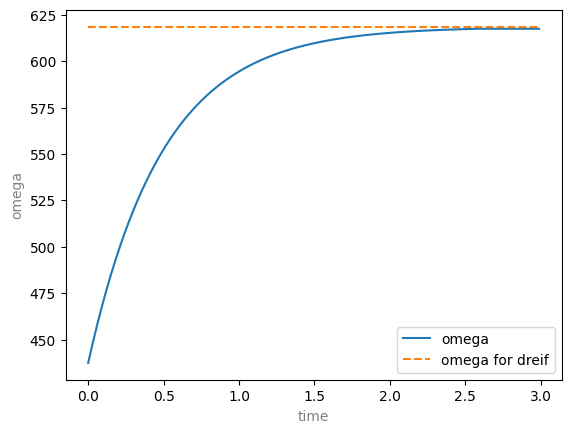

In [2]:
#скорость изменения угловой скорости с текущей до целевой
def domega(start, end):
    if abs(end - start) <= 1:
        return 0
    else:
        return (end - start) / Tw

# массив угловых скоростей на программном движении
def omega_gen(omega0, omegaend, t):
    omega = [omega0[0]]       
    for i in range(len(t) - 1):
        omega.append(omega[-1] + h * domega(omega[-1], omegaend[0]))
    return omega

omega = list(omega_gen(omega0, omegadreif, t))

print(omega[0], omega[-1])

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(t, omega)

plt.plot(t, [omegadreif[0] for _t in t], "--")
plt.legend(['omega', 'omega for dreif'])
plt.xlabel('time', color='gray')
plt.ylabel('omega',color='gray')
plt.show()

In [3]:
from numpy import matmul
from numpy import array as arr

from numpy import cross

def dpqr(w, p, q, r, u=list([0, 0])): 
    return [(                        - (IQz - IQx) * q * r - IPz * q * (w[0] + w[1]) )       / IBx,
            ((f(w[0]) - f(w[1])) * l + (IQz - IQx) * p * r + IPz * p * (w[0] + w[1]) + u[1]) / IBx,
            (IPz * w[0] + IPz * w[1] - gamma * r + km * (f(w[0]) + f(w[1])))                 / IBz]

# угловые скорости по осям для программного движения
def pqr_gen(omega, pqr0, t):
    pqr = [pqr0]
    for i in range(len(t) - 1):
        pqr.append([pqr[-1][0] + h * dpqr([omega[i+1], omega[i+1]], pqr[-1][0], pqr[-1][1], pqr[-1][2])[0], 
                    pqr[-1][1] + h * dpqr([omega[i+1], omega[i+1]], pqr[-1][0], pqr[-1][1], pqr[-1][2])[1],
                    pqr[-1][2] + h * dpqr([omega[i+1], omega[i+1]], pqr[-1][0], pqr[-1][1], pqr[-1][2])[2]])
    return pqr

pqr = pqr_gen(omega, [0, 0, 0], t)

p = [item[0] for item in pqr]
q = [item[1] for item in pqr]
r = [item[2] for item in pqr]


In [4]:


# матрица ориентации через углы Эйлера
def R(psi, tetta, phi):
    Rpsi = arr([[cos(psi), -sin(psi), 0],
               [sin(psi), cos(psi), 0],
               [0, 0, 1]])
    Rtetta = arr([[1, 0, 0],
               [0, cos(tetta), -sin(tetta)],
               [0, sin(tetta), cos(tetta)]])
    Rphi = arr([[cos(phi), -sin(phi), 0],
               [sin(phi), cos(phi), 0],
               [0, 0, 1]])
    return matmul(matmul(Rpsi, Rtetta), Rphi)

# производные углов через угловую скорость тела
def dangles(psi, tetta, phi, p, q, r):
    dpsi = (p * sin(phi) + q * cos(phi)) / sin(tetta) if tetta != 0 else 0
    dtetta = p * cos(phi) - q * sin(phi)
    dphi = r - (p * sin(phi) - q * cos(phi)) / tan(tetta) if tetta != 0 else r
    return dpsi, dtetta, dphi

angles = [arr([0, 0, 0])]

R0 = arr([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],])

def R_gen(angles, p, q, r):
    Rar = [R0]
    for i in range(len(t) - 1):
        angles.append(angles[-1] + h * arr(dangles(angles[-1][0], angles[-1][1], angles[-1][2], p[i+1], q[i+1], r[i+1])))
        Rar.append(R(angles[-1][0], angles[-1][1], angles[-1][2]))
    return Rar

Rar = R_gen(angles, p, q, r)

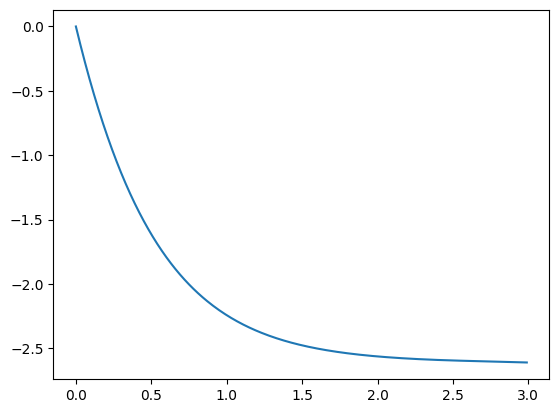

In [5]:

# второй закон Ньютона
def d2d(R, w1, w3):
    result = [R[i][2] * (f(w1) + f(w3)) / m for i in range(3)]
    result[2] -= g
    return result

def d_v(omega):
    
    vd = [arr([0, 0, 0])]
    for i in range(len(t) - 1): 
        vd.append(vd[-1] + arr([h, h, h]) * arr(d2d(Rar[i+1], omega[i+1], omega[i+1])))
    

    d = [[0, 0, 5]]
    for i in range(len(t) - 1):
        d.append(arr(d[-1]) + arr([h, h, h]) * vd[i+1])
        if d[-1][2] < 0: 
            d[-1][2] = 0
    
    return d, vd


d_current, v = d_v(omega)

plt.plot(t, [item[2] for item in v])
plt.show()

In [6]:
#управление по угловой скорости на программной кривой, то есть U суммы и U разности
def u(w):
    return [f(w[0]) + f(w[2]), f(w[0]) - f(w[2])]

n0 = [0, 0, 1]

# вектор нормали квадрокоптера через матрицу ориентации (для программного движения)
def n(R):  # где R - матрица ориентации
    return matmul(arr(R), arr([0, 0, 1]))

# производная от нормали при движении с отклонениями
def dn(pqr, n):
    return cross( - arr(pqr), arr(n))

In [7]:
from control import lqr

def A(r, w):
    a = ((IQx - IQz) * r - IPz * (w[0] + w[1])) / IBx
    return [[ 0, a, 0, 0],
            [-a, 0, 0, 0],
            [ 0,-1, 0, r],
            [ 1, 0,-r, 0]]

B = [[0], [l / IBx], [0], [0]]

Rlqr = 100
Qlqr = [[0.01, 0, 0, 0],
        [0, 0.01, 0, 0],
        [0, 0, 0.01, 0],
        [0, 0, 0, 0.01]]

def gen_lqr(omega, pqr0, t):
        _pqr = [pqr0]
        for i in range(len(t) - 1):
                K, S, E = lqr(A(pqr[i][2], [omega[i], omega[i]]), B, Qlqr, Rlqr)
                u = [K[0][j] * (pqr[i][j] - _pqr[-1][j]) for j in range(2)]
                _pqr.append([_pqr[-1][0] + h * dpqr([omega[i+1], omega[i+1]], _pqr[-1][0], _pqr[-1][1], _pqr[-1][2], u)[0], 
                             _pqr[-1][1] + h * dpqr([omega[i+1], omega[i+1]], _pqr[-1][0], _pqr[-1][1], _pqr[-1][2], u)[1],
                             _pqr[-1][2] + h * dpqr([omega[i+1], omega[i+1]], _pqr[-1][0], _pqr[-1][1], _pqr[-1][2], u)[2]])
        return _pqr

_pqr = gen_lqr(omega, [0.01, 0.01, 0.01], t)

print(_pqr[-1], pqr[-10])


[9.42704721811411e-06, 9.59459672644872e-05, 22.21112523002159] [0.0, 0.0, 21.847148336229658]


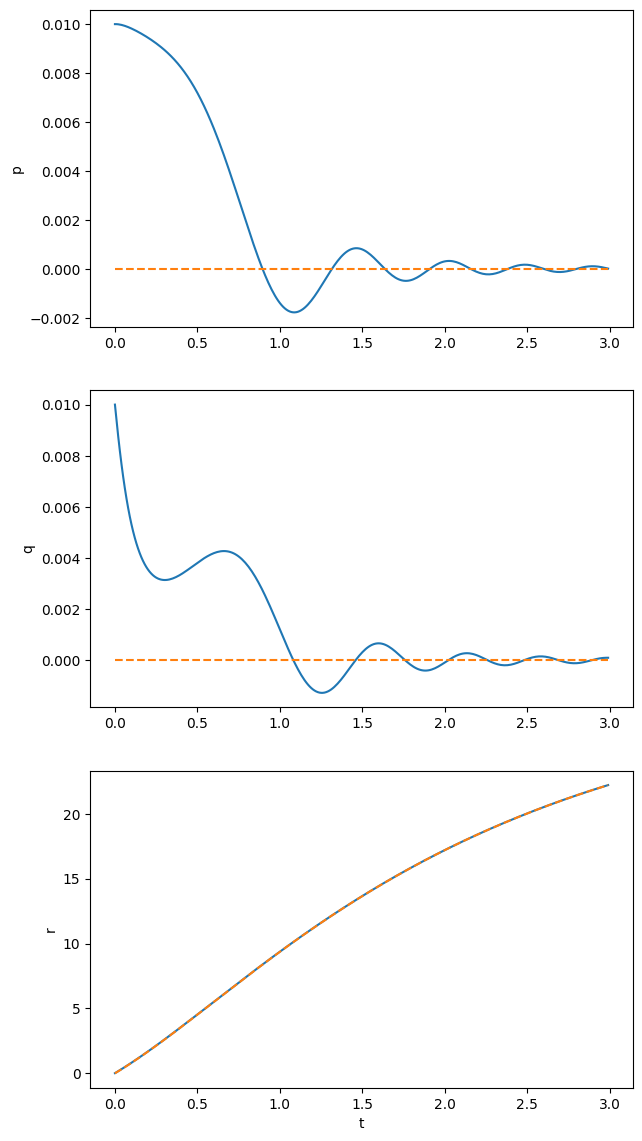

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=False, figsize=(7,14))
p = [item[0] for item in pqr]
_p = [item[0] for item in _pqr]
ax1.plot(t, _p, '-', t, p, '--')
ax1.set_ylabel('p')
#
q = [item[1] for item in pqr]
_q = [item[1] for item in _pqr]
ax2.plot(t, _q, '-', t, q, '--')
ax2.set_ylabel('q')
#ax2.plot(t, q)

r = [item[2] for item in pqr]
_r = [item[2] for item in _pqr]
ax3.plot(t, _r, '-', t, r, '--')
ax3.set_ylabel('r')
ax3.set_xlabel('t')
#ax3.plot(t, r)
plt.show()

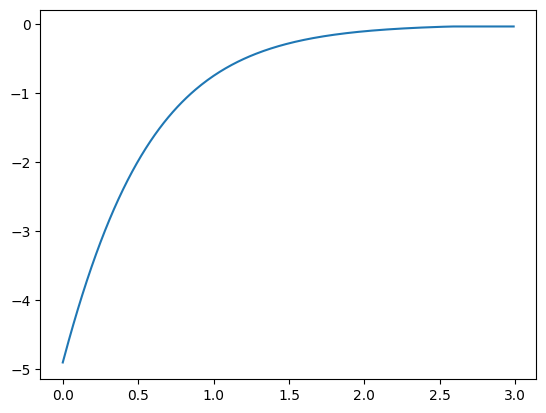

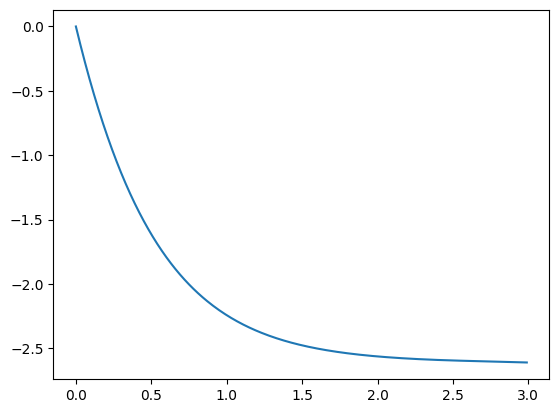

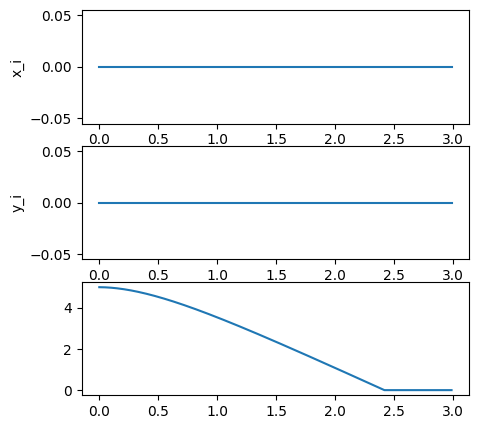

In [9]:

plt.plot(t, [(Rar[i][2] * 2 * f(omega[i])/m - [0, 0, g])[2] for i in range(len(t))])
plt.show()
d_current, v = d_v(omega)

plt.plot(t, [item[2] for item in v])
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=False, figsize=(5,5))
ax1.plot(t, [d_current[i][0] for i in range((len(d_current)))])
ax1.set_xlabel('t')
ax1.set_ylabel('x_i')
ax2.plot(t, [d_current[i][1] for i in range((len(d_current)))])
ax2.set_xlabel('t')
ax2.set_ylabel('y_i')
ax3.plot(t, [d_current[i][2] for i in range((len(d_current)))])
plt.show()


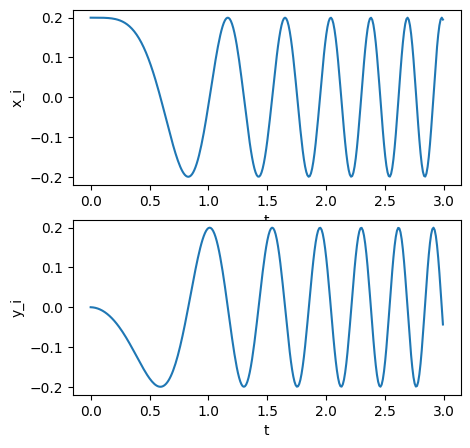

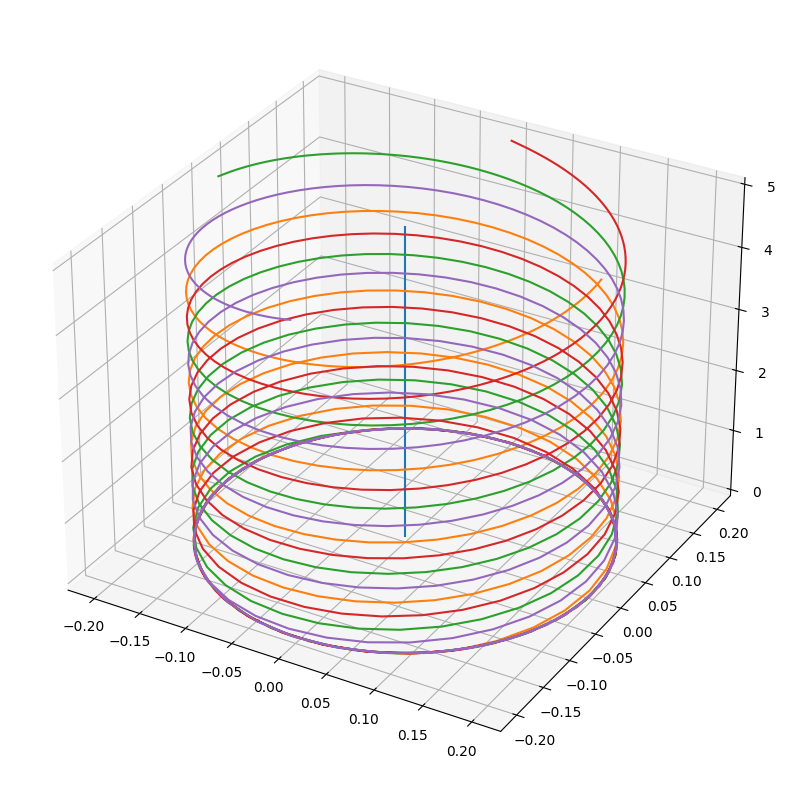

In [10]:
from mpl_toolkits.mplot3d import Axes3D

x = [d_current[i][0] for i in range(len(t))]
y = [d_current[i][1] for i in range(len(t))]
z = [d_current[i][2] for i in range(len(t))]

xi = [arr(matmul(arr([l, 0, 0]), Rar[i]))[0] + arr(x[i]) for i in range(len(x))] 
yi = [arr(matmul(arr([l, 0, 0]), Rar[i]))[1] + arr(y[i]) for i in range(len(x))] 

fig, (ax1, ax2) = plt.subplots(2, 1, sharey=False, figsize=(5,5))
ax1.plot(t, xi)
#ax1.set_ylim(0, w0[0] * 2)
ax1.set_xlabel('t')
ax1.set_ylabel('x_i')
ax2.plot(t, yi)
ax2.set_xlabel('t')
ax2.set_ylabel('y_i')

x1 = [arr(matmul(arr([l, 0, 0]), Rar[i]))[0] + arr(x[i]) for i in range(len(t))] 
y1 = [arr(matmul(arr([l, 0, 0]), Rar[i]))[1] + arr(y[i]) for i in range(len(t))] 
z1 = [arr(matmul(arr([l, 0, 0]), Rar[i]))[2] + arr(z[i]) for i in range(len(t))]
x2 = [arr(matmul(arr([-l, 0, 0]), Rar[i]))[0] + arr(x[i]) for i in range(len(t))] 
y2 = [arr(matmul(arr([-l, 0, 0]), Rar[i]))[1] + arr(y[i]) for i in range(len(t))] 
z2 = [arr(matmul(arr([-l, 0, 0]), Rar[i]))[2] + arr(z[i]) for i in range(len(t))]
x3 = [arr(matmul(arr([0, l, 0]), Rar[i]))[0] + arr(x[i]) for i in range(len(t))] 
y3 = [arr(matmul(arr([0, l, 0]), Rar[i]))[1] + arr(y[i]) for i in range(len(t))] 
z3 = [arr(matmul(arr([0, l, 0]), Rar[i]))[2] + arr(z[i]) for i in range(len(t))]
x4 = [arr(matmul(arr([0, -l, 0]), Rar[i]))[0] + arr(x[i]) for i in range(len(t))] 
y4 = [arr(matmul(arr([0, -l, 0]), Rar[i]))[1] + arr(y[i]) for i in range(len(t))] 
z4 = [arr(matmul(arr([0, -l, 0]), Rar[i]))[2] + arr(z[i]) for i in range(len(t))]

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='parametric curve')
ax.plot(x1, y1, z1, label='parametric curve')
ax.plot(x2, y2, z2, label='parametric curve')
ax.plot(x3, y3, z3, label='parametric curve')
ax.plot(x4, y4, z4, label='parametric curve')
plt.show()

-2.6092067848567715


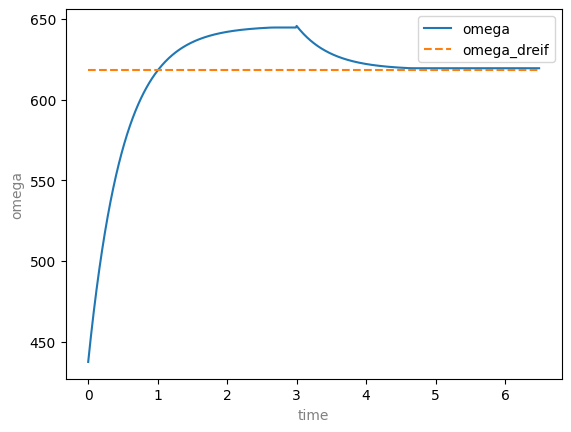

In [11]:
t_temp = arange(T, T + 3.5, h)


v_0 = v[-1][2]
print(v_0)

om1 = omega_gen(omega0, 1.0439 * arr(omegadreif), t)
om1 = list(om1) + list(omega_gen(1.0439 * arr(omegadreif), 0.9999*arr(omegadreif), t_temp))
plt.plot(list(t)+ list(t_temp), om1)
plt.plot(list(t)+ list(t_temp), [omegadreif[0] for _t in (list(t)+ list(t_temp))], '--')
plt.legend(['omega', 'omega_dreif'])
plt.xlabel('time', color = 'gray')
plt.ylabel('omega', color = 'gray')
plt.show()

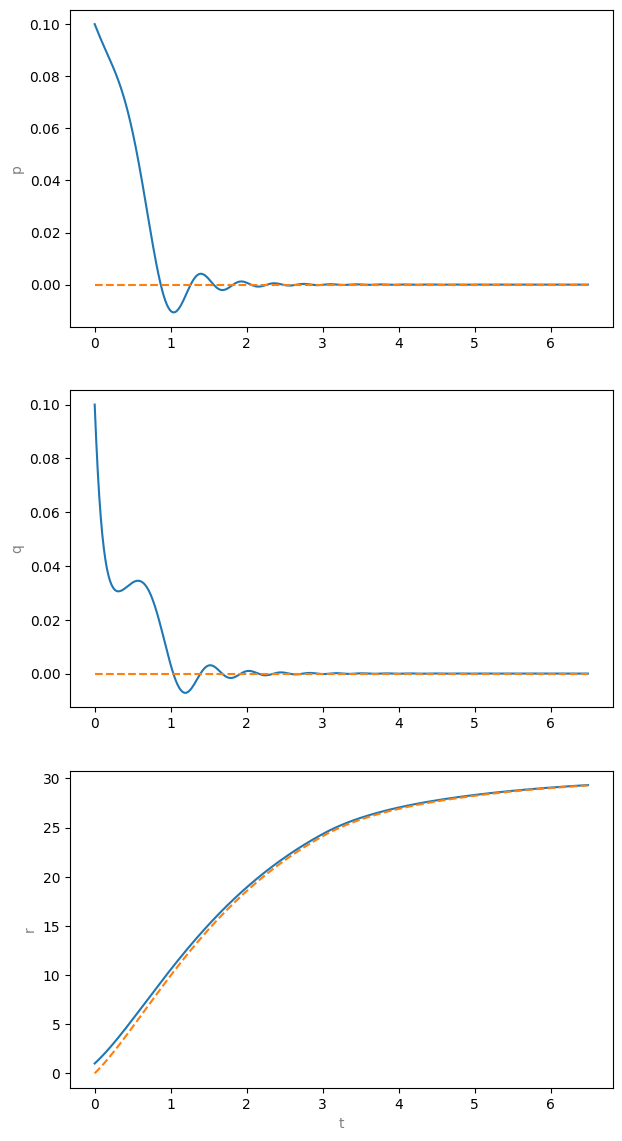

In [12]:
t = list(t)+ list(t_temp)

Rlqr = 60
Qlqr = [[0.01, 0, 0, 0],
        [0, 0.01, 0, 0],
        [0, 0, 0.01, 0],
        [0, 0, 0, 0.01]]

pqr = pqr_gen(om1, [0, 0, 0], t)
_pqr = gen_lqr(om1, [0.1, 0.1, 1], t)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=False, figsize=(7,14))
p = [item[0] for item in pqr]
_p = [item[0] for item in _pqr]
ax1.plot(t, _p, '-', t, p, '--')
ax1.set_ylabel('p', color = 'grey')
#
q = [item[1] for item in pqr]
_q = [item[1] for item in _pqr]
ax2.plot(t, _q, '-', t, q, '--')
ax2.set_ylabel('q', color = 'grey')
#ax2.plot(t, q)

r = [item[2] for item in pqr]
_r = [item[2] for item in _pqr]
ax3.plot(t, _r, '-', t, r, '--')
ax3.set_ylabel('r', color = 'grey')
ax3.set_xlabel('t', color = 'grey')
#ax3.plot(t, r)
plt.show()

[ 0.          0.         -0.00107369]


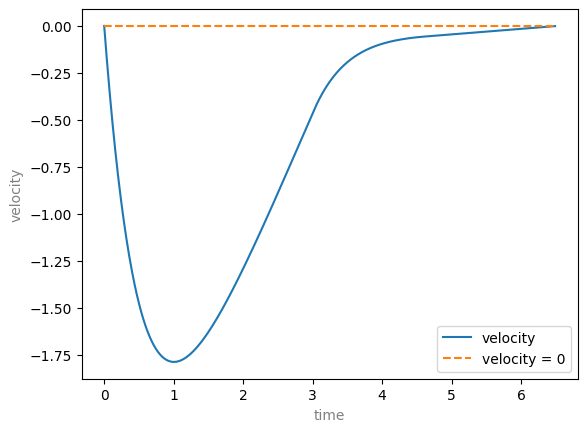

In [13]:
angles = [arr([0, 0, 0])]
Rar = R_gen(angles, p, q, r)

d_current, v = d_v(om1)

print(v[-1])

plt.plot(t, [item[2] for item in v])
plt.plot(t, [0 for _t in t], '--')
plt.legend(['velocity', 'velocity = 0'])
plt.xlabel('time', color = 'gray')
plt.ylabel('velocity', color = 'gray')
plt.show()

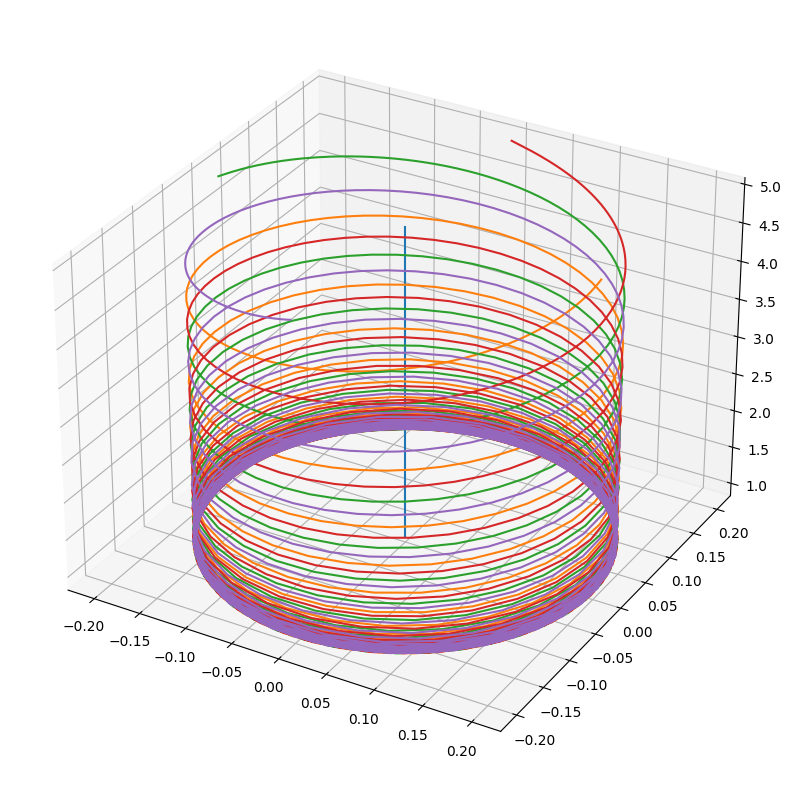

In [14]:
x = [d_current[i][0] for i in range(len(t))]
y = [d_current[i][1] for i in range(len(t))]
z = [d_current[i][2] for i in range(len(t))]

x1 = [arr(matmul(arr([l, 0, 0]), Rar[i]))[0] + arr(x[i]) for i in range(len(t))] 
y1 = [arr(matmul(arr([l, 0, 0]), Rar[i]))[1] + arr(y[i]) for i in range(len(t))] 
z1 = [arr(matmul(arr([l, 0, 0]), Rar[i]))[2] + arr(z[i]) for i in range(len(t))]
x2 = [arr(matmul(arr([-l, 0, 0]), Rar[i]))[0] + arr(x[i]) for i in range(len(t))] 
y2 = [arr(matmul(arr([-l, 0, 0]), Rar[i]))[1] + arr(y[i]) for i in range(len(t))] 
z2 = [arr(matmul(arr([-l, 0, 0]), Rar[i]))[2] + arr(z[i]) for i in range(len(t))]
x3 = [arr(matmul(arr([0, l, 0]), Rar[i]))[0] + arr(x[i]) for i in range(len(t))] 
y3 = [arr(matmul(arr([0, l, 0]), Rar[i]))[1] + arr(y[i]) for i in range(len(t))] 
z3 = [arr(matmul(arr([0, l, 0]), Rar[i]))[2] + arr(z[i]) for i in range(len(t))]
x4 = [arr(matmul(arr([0, -l, 0]), Rar[i]))[0] + arr(x[i]) for i in range(len(t))] 
y4 = [arr(matmul(arr([0, -l, 0]), Rar[i]))[1] + arr(y[i]) for i in range(len(t))] 
z4 = [arr(matmul(arr([0, -l, 0]), Rar[i]))[2] + arr(z[i]) for i in range(len(t))]

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='parametric curve')
ax.plot(x1, y1, z1, label='parametric curve')
ax.plot(x2, y2, z2, label='parametric curve')
ax.plot(x3, y3, z3, label='parametric curve')
ax.plot(x4, y4, z4, label='parametric curve')
plt.show()

0.2129119150940451


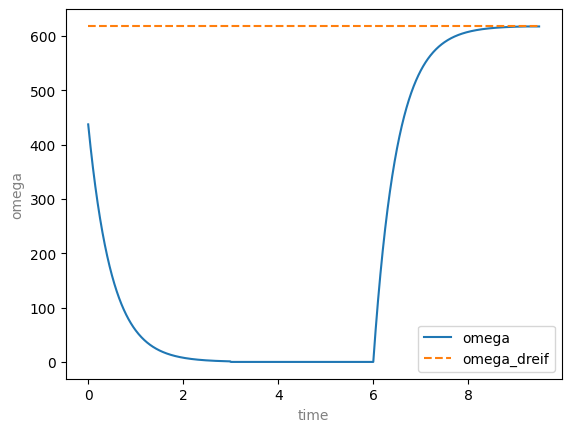

In [15]:
t = arange(0, T, h)
t_temp = arange(T + 3, T + 6.5, h)
t_uncontrol = arange(T, T + 3, h)

omega_uncontrol = [sqrt(gamma * (IPz/IBx) / (km * kf * (1 - (IQz - IQx) / IBx))), 0, sqrt(gamma * (IPz/IBx) / (km * kf * (1 - (IQz - IQx) / IBx))), 0]

print(omega_uncontrol[0])

om1 = omega_gen(omega0, omega_uncontrol, t)
om1 = list(om1) + [omega_uncontrol[0] for _t in t_uncontrol]
om1 = list(om1) + list(omega_gen(omega_uncontrol, omegadreif, t_temp))
t = t = list(t) + list(t_uncontrol) + list(t_temp)
plt.plot(t, om1)
plt.plot(t, [omegadreif[0] for _t in t], '--')
plt.legend(['omega', 'omega_dreif'])
plt.xlabel('time', color = 'gray')
plt.ylabel('omega', color = 'gray')
plt.show()

[0.05215847 0.00366736 0.69135389]


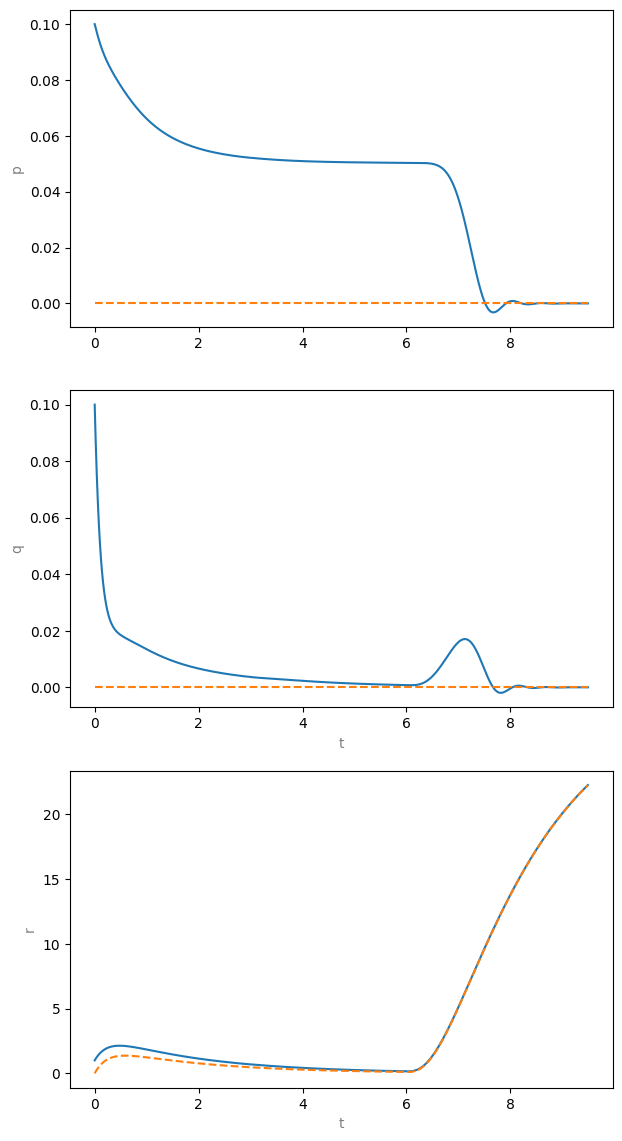

In [16]:

Rlqr = 60
Qlqr = [[0.01, 0, 0, 0],
        [0, 0.01, 0, 0],
        [0, 0, 0.01, 0],
        [0, 0, 0, 0.01]]

pqr = pqr_gen(om1, [0, 0, 0], t)
_pqr = gen_lqr(omega_gen(omega0, omega_uncontrol, arange(0, T, h)), [0.1, 0.1, 1], arange(0, T, h))
_pqr10 = arr(_pqr[-1]) # + arr([0.1, 0.1, 1])
print(_pqr10)
_pqr = list(_pqr) + list(gen_lqr([omega_uncontrol[0] for _t in t_uncontrol] + list(omega_gen(omega_uncontrol, omegadreif, t_temp)), 
                                  _pqr10, list(t_uncontrol) + list(t_temp)))


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=False, figsize=(7,14))
p = [item[0] for item in pqr]
_p = [item[0] for item in _pqr]
ax1.plot(t, _p, '-', t, p, '--')
ax1.set_ylabel('p', color = 'grey')
#
q = [item[1] for item in pqr]
_q = [item[1] for item in _pqr]
ax2.plot(t, _q, '-', t, q, '--')
ax2.set_ylabel('q', color = 'grey')
ax2.set_xlabel('t', color = 'grey')
#ax2.plot(t, q)

r = [item[2] for item in pqr]
_r = [item[2] for item in _pqr]
ax3.plot(t, _r, '-', t, r, '--')
ax3.set_ylabel('r', color = 'grey')
ax3.set_xlabel('t', color = 'grey')
#ax3.plot(t, r)
plt.show()